## Test the Performance of Sparse Linear Regression/Short Trees

Test the performance of sparse linear regression/sparse trees to see how well we can predict with limited resources as well as what features are appearing in models.

In [1]:
import numpy as np
import os, sys, copy
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Load the data
metadata = pd.read_csv('../data/metafile_0922.csv', index_col=0, header=None, names=['feature', 'description'])
data = pd.read_csv('../data/global_dams_db_0922.csv')

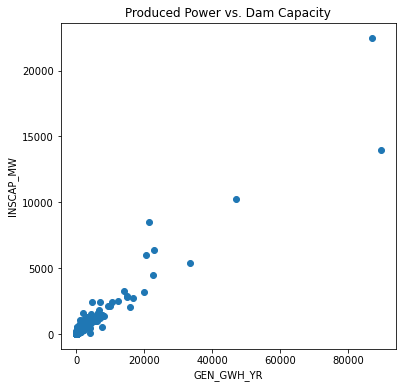

In [3]:
# Compare dam capacity and generated GWH/yr
fig = plt.figure(figsize=(6,6))
plt.scatter(data['GEN_GWH_YR'], data['INSCAP_MW'])
plt.xlabel('GEN_GWH_YR')
plt.ylabel('INSCAP_MW')
plt.title('Produced Power vs. Dam Capacity')
plt.show()

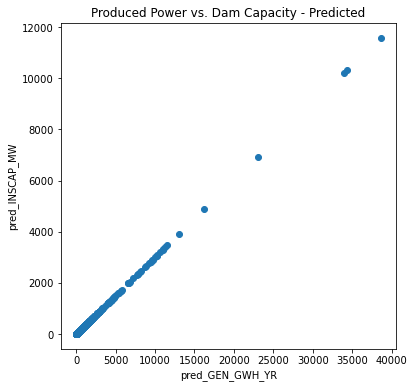

In [4]:
# Compare predicted dam capacity and predicted generated GWH/yr
fig = plt.figure(figsize=(6,6))
plt.scatter(data['pred_GEN_GWH_YR'], data['pred_INSCAP_MW'])
plt.xlabel('pred_GEN_GWH_YR')
plt.ylabel('pred_INSCAP_MW')
plt.title('Produced Power vs. Dam Capacity - Predicted')
plt.show()

In [5]:
# Delare a vector of features to use
# features = ['DAM_HGT_M', 'DAM_LEN_M', 'AREA_SKM', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM', 
#             'GDP_capita', 'Population', 'run_mm_syr', 'inu_pc_umn', 'sgr_dk_sav', 'clz_cl_smj', 'ari_ix_sav', 
#             'ari_ix_uav', 'glc_cl_smj', 'pnv_cl_smj', 'wet_cl_smj', 'for_pc_use', 'crp_pc_use', 'pst_pc_use', 
#             'ire_pc_use', 'gla_pc_use', 'prm_pc_use', 'pac_pc_use', 'fmh_cl_smj', 'soc_th_uav', 'swc_pc_uyr', 
#             'lit_cl_smj', 'ero_kh_uav', 'pop_ct_usu', 'ppd_pk_uav', 'urb_pc_use', 'hft_ix_u09', 'hdi_ix_sav']

features = ['DAM_HGT_M', 'DAM_LEN_M', 'AREA_SKM', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM', 
            'GDP_capita', 'Population', 'run_mm_syr', 'inu_pc_umn', 'sgr_dk_sav', 'ari_ix_sav', 'ari_ix_uav', 
            'for_pc_use', 'crp_pc_use', 'pst_pc_use', 'ire_pc_use', 'gla_pc_use', 'prm_pc_use', 'pac_pc_use', 
            'soc_th_uav', 'swc_pc_uyr', 'ero_kh_uav', 'pop_ct_usu', 'ppd_pk_uav', 'urb_pc_use', 'hft_ix_u09', 
            'hdi_ix_sav', 'YEAR', 'CAP_MCM', 'RES_YLD_TN', 'RES_LSS_TN', 'CO2_per_GWH', 'fish_per_GWH']

In [6]:
# Change categorial features to one-hot encoding
categorial_features = ['clz_cl_smj', 'glc_cl_smj', 'pnv_cl_smj', 'wet_cl_smj', 
                       'fmh_cl_smj', 'lit_cl_smj', 'MAIN_USE', 'LAKE_CTRL']

for feature in categorial_features:
    categories = pd.unique(data[feature])
    for category in categories:
        key = '{}-{}'.format(feature, category)
        data[key] = data[feature].apply(lambda x: 1 if x == category else 0)
        features.append(key)

In [7]:
len(features)

144

In [8]:
# Add columns for CO2 per GWH and fish per GWH
data['CO2_per_GWH'] = data.apply(lambda x: x['CO2EQ_areal']/x['GEN_GWH_YR'], axis=1)
data['fish_per_GWH'] = data.apply(lambda x: (x['RES_BAL']/x['GEN_GWH_YR']), axis=1)

In [9]:
# Look at highly correlated features
cor = data.corr()
cor_table = cor.stack().reset_index().rename(columns={'level_0':'feature_1','level_1':'feature_2', 0:'cor'})
cor_table = cor_table[(cor_table.feature_1 > cor_table.feature_2)]
thresh = 0.8
filt_table = cor_table[(cor_table.cor > thresh) | (cor_table.cor < -thresh)]
filt_table.sort_values(by='cor', ascending=False)

feature_1            feature_2       cor
3260    pred_INSCAP_MW      pred_GEN_GWH_YR  1.000000
3240    pred_INSCAP_MW             REM_YEAR  1.000000
20901  lit_cl_smj-16.0      fmh_cl_smj-98.0  1.000000
3509   pred_GEN_GWH_YR             REM_YEAR  1.000000
2388        RES_LSS_TN              RES_BAL  0.994301
3127         INSCAP_MW           GEN_GWH_YR  0.960937
4436        ari_ix_uav           ari_ix_sav  0.928361
3673        run_mm_syr           ari_ix_sav  0.873897
7476        hdi_ix_sav           GDP_capita  0.853299
3674        run_mm_syr           ari_ix_uav  0.846017
22971     fish_per_GWH          CO2_per_GWH  0.841455
6422        swc_pc_uyr           ari_ix_uav  0.830013
3515   pred_GEN_GWH_YR           DIS_AVG_LS  0.829727
3246    pred_INSCAP_MW           DIS_AVG_LS  0.829727
16592  wet_cl_smj-11.0           wet_cl_smj  0.809011
8227   clz_cl_smj-14.0             REM_YEAR -0.840297
13991   pnv_cl_smj-4.0             REM_YEAR -0.840297
386           REM_YEAR  MAIN_USE-Recreation -0.840297

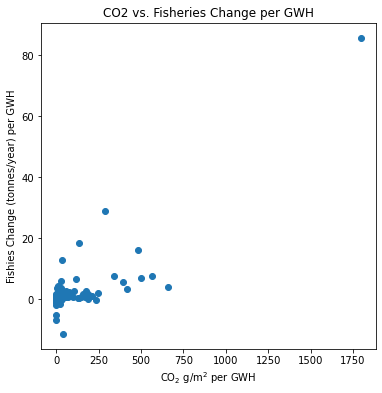

In [10]:
# Plot fisheries gain versus CO2 emissions
fig = plt.figure(figsize=(6,6))
plt.scatter(data['CO2_per_GWH'], data['fish_per_GWH'])
plt.xlabel('CO$_2$ g/m$^2$ per GWH')
plt.ylabel('Fishies Change (tonnes/year) per GWH')
plt.title('CO2 vs. Fisheries Change per GWH')
plt.show()

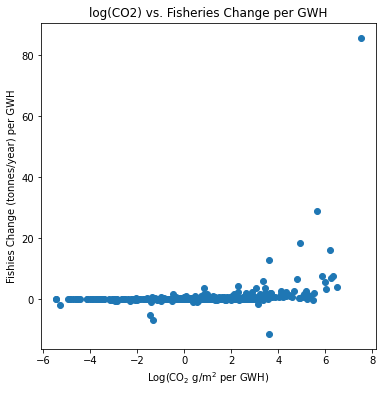

In [11]:
# Plot fisheries gain versus CO2 emissions
fig = plt.figure(figsize=(6,6))
plt.scatter(np.log(data['CO2_per_GWH']), data['fish_per_GWH'])
plt.xlabel('Log(CO$_2$ g/m$^2$ per GWH)')
plt.ylabel('Fishies Change (tonnes/year) per GWH')
plt.title('log(CO2) vs. Fisheries Change per GWH')
plt.show()

### Sparse Regression

In [12]:
from sklearn import linear_model
from scipy.stats import pearsonr
from sklearn.utils.multiclass import type_of_target
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### CO2 per GWH

In [13]:
# Filter for dams with CO2 and power information
data_filt = data[data['CO2_per_GWH'].apply(lambda x: not pd.isna(x))]
data_filt = data_filt[features]
data_filt.shape

(477, 144)

In [14]:
# Create cummulative GHG totals over dams
data_filt = data_filt.sort_values(by='CO2_per_GWH')
data_filt['CO2_rank'] = np.arange(0, data_filt.shape[0])
data_filt['CO2_cumsum'] = data_filt['CO2_per_GWH'].cumsum()

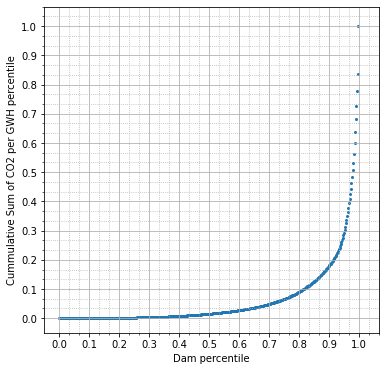

In [15]:
# Create a plot of cummulative sum versus rank by percentile for the CO2 values
fig = plt.figure(figsize=(6,6))
plt.scatter(data_filt['CO2_rank']/data_filt.shape[0], data_filt['CO2_cumsum']/max(data_filt['CO2_cumsum']), s=4)
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
ax = plt.gca()
ax.set_xticks(np.arange(0,1.1,1/30), minor=True)
ax.set_yticks(np.arange(0,1.1,1/30), minor=True)
plt.xlabel('Dam percentile')
plt.ylabel('Cummulative Sum of CO2 per GWH percentile')
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle=':')
plt.show()


In [16]:
# Generate the test and training data 
X = data_filt.drop(columns=['CO2_per_GWH','CO2_rank', 'CO2_cumsum'], inplace=False)
y = np.log(data_filt['CO2_per_GWH'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

In [17]:
# Standardize the data (i.e. set mean to 0 and std to 1)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [18]:
# Check for features containing NAs
nas = X.isnull().sum()
nas = nas[nas != 0]
nas

DAM_LEN_M       36
YEAR             1
RES_YLD_TN      24
RES_LSS_TN      24
fish_per_GWH    24
dtype: int64

In [19]:
# For now, drop columns with NAs. Could potentially use imputation
X.drop(columns=list(nas.index), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [20]:
# Define alphas
alphas = [50, 25, 10, 5, 1, 0.5, 0]

In [21]:
# Train models and record R2 values and the number of parameters
test_r2s = np.zeros(len(alphas))
train_r2s = np.zeros(len(alphas))
n_params = np.zeros(len(alphas))
coeffs = {}
y_pred_test = {}
y_pred_train = {}

for i in range(len(alphas)):
    alpha = alphas[i]
    if alpha == 0:
        reg = linear_model.LinearRegression()
    else:
        reg = linear_model.Lasso(alpha=alpha)
    reg.fit(X_train, y_train)    
    test_r2s[i] = reg.score(X_test, y_test)
    train_r2s[i] = reg.score(X_train, y_train)
    y_pred_test[alpha] = reg.predict(X_test)
    y_pred_train[alpha] = reg.predict(X_train)
    coeffs[alpha] = reg.coef_
    n_params[i] = len(coeffs[alpha][coeffs[alpha] != 0])

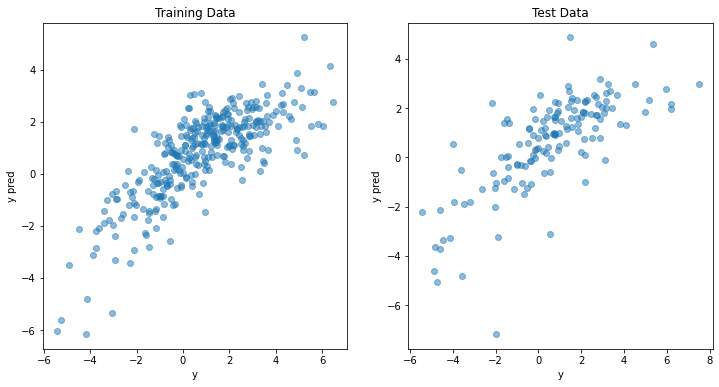

In [22]:
# Plot the y-values verus the predicted y-values for the regular regression
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_test[alphas[4]], alpha=0.5)
plt.xlabel('y')
plt.ylabel('y pred')
plt.title('Test Data')

plt.subplot(1,2,1)
plt.scatter(y_train, y_pred_train[alphas[4]], alpha=0.5)
plt.xlabel('y')
plt.ylabel('y pred')
plt.title('Training Data')
plt.show()


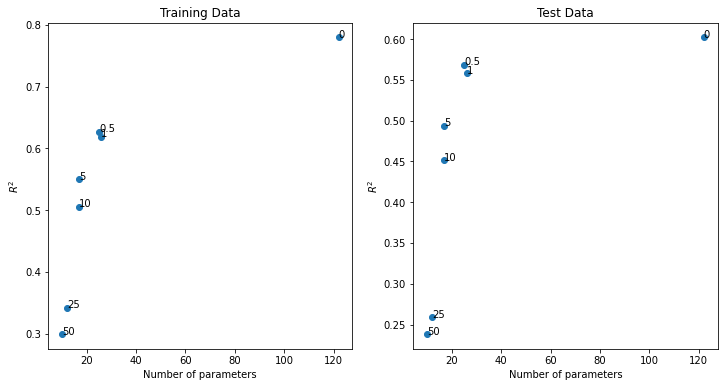

In [23]:
# Plot the R2 values of the models
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(n_params, train_r2s)
for i in range(len(n_params)):
    plt.text(n_params[i], train_r2s[i], s=alphas[i])
plt.xlabel('Number of parameters')
plt.ylabel('$R^2$')
plt.title('Training Data')

plt.subplot(1,2,2)
plt.scatter(n_params, test_r2s)
for i in range(len(n_params)):
    plt.text(n_params[i], test_r2s[i], s=alphas[i])
plt.xlabel('Number of parameters')
plt.ylabel('$R^2$')
plt.title('Test Data')
plt.show()


In [24]:
train_r2s

array([0.29958583, 0.34202143, 0.50553096, 0.54981432, 0.61887991,
       0.62719007, 0.77937525])

In [25]:
# Create summary dataframes
summary = {}
for alpha in alphas:
    summary[alpha] = pd.DataFrame(columns=['feature', 'coeff'], data=np.array([X.columns[coeffs[alpha] > 0], coeffs[alpha][coeffs[alpha] > 0]]).T)
    summary[alpha] = summary[alpha].join(metadata, on='feature')
    summary[alpha].sort_values(by='coeff', inplace=True, ascending=False)

In [26]:
summary[0.5]

feature        coeff                                        description
4  pac_pc_use    0.0182702  Protected area extent, in percent, in total wa...
6  hft_ix_u09   0.00834466  Average human footprint as of 2009, in percent...
3  crp_pc_use   0.00742034  Cropland extent, in percent, in total watershe...
2  for_pc_use    0.0051525  Forest cover extent, in percent, in total wate...
7  hdi_ix_sav   0.00258188                    Average human development index
0  run_mm_syr   0.00112175                         Land surface runoff, in mm
1  sgr_dk_sav   0.00069186  Stream gradient, in decimeters per km, along t...
5  pop_ct_usu  3.48491e-05              Population count, thousands of people

### Change in Fish per GWH

In [27]:
# Filter for dams with fish and power information
data_filt = data[data['fish_per_GWH'].apply(lambda x: not pd.isna(x))]
data_filt = data_filt[features]

# Generate the test and training data 
X = data_filt.drop(columns=['fish_per_GWH'], inplace=False)
y = np.log(np.abs(data_filt['fish_per_GWH'])) * np.sign(data_filt['fish_per_GWH'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Check for features containing NAs
nas = X.isnull().sum()
nas = nas[nas != 0]

# For now, drop columns with NAs. Could potentially use imputation
X.drop(columns=list(nas.index), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data (i.e. set mean to 0 and std to 1)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [28]:
# Create cummulative GHG totals over dams
data_filt = data_filt.sort_values(by='fish_per_GWH')
data_filt['fish_rank'] = np.arange(0, data_filt.shape[0])
data_filt['fish_cumsum'] = data_filt['fish_per_GWH'].cumsum()

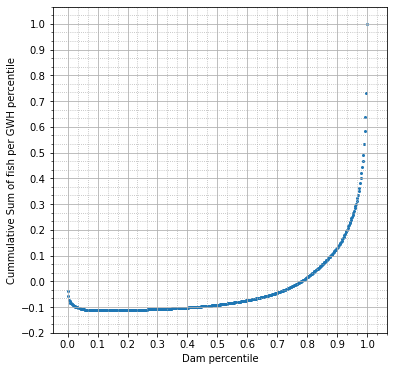

In [29]:
# Create a plot of cummulative sum versus rank by percentile for the fish values
fig = plt.figure(figsize=(6,6))
plt.scatter(data_filt['fish_rank']/data_filt.shape[0], data_filt['fish_cumsum']/max(data_filt['fish_cumsum']), s=4)
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(-.2,1.1,0.1))
ax = plt.gca()
ax.set_xticks(np.arange(0,1.1,1/30), minor=True)
ax.set_yticks(np.arange(-.2,1.1,1/30), minor=True)
plt.xlabel('Dam percentile')
plt.ylabel('Cummulative Sum of fish per GWH percentile')
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle=':')
plt.show()


In [30]:
# Define alphas
alphas = [1, 0.5, 0.1, 0.05, 0]

In [31]:
# Train models and record R2 values and the number of parameters
test_r2s = np.zeros(len(alphas))
train_r2s = np.zeros(len(alphas))
n_params = np.zeros(len(alphas))
coeffs = {}
y_pred_test = {}
y_pred_train = {}

for i in range(len(alphas)):
    alpha = alphas[i]
    if alpha == 0:
        reg = linear_model.LinearRegression()
    else:
        reg = linear_model.Lasso(alpha=alpha)
    reg.fit(X_train, y_train)    
    test_r2s[i] = reg.score(X_test, y_test)
    train_r2s[i] = reg.score(X_train, y_train)
    y_pred_test[alpha] = reg.predict(X_test)
    y_pred_train[alpha] = reg.predict(X_train)
    coeffs[alpha] = reg.coef_
    n_params[i] = len(coeffs[alpha][coeffs[alpha] != 0])

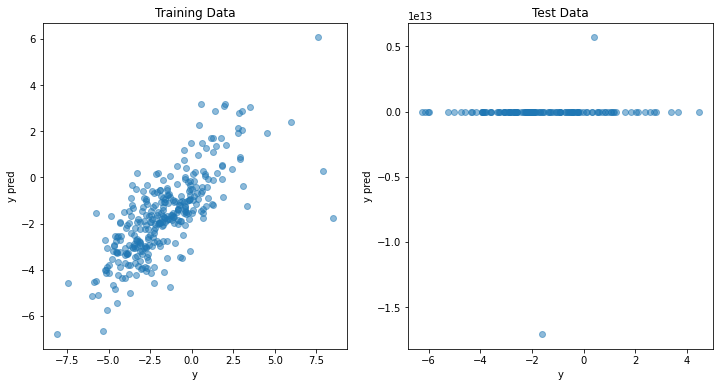

In [32]:
# Plot the y-values verus the predicted y-values for the regular regression
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_test[alphas[4]], alpha=0.5)
plt.xlabel('y')
plt.ylabel('y pred')
plt.title('Test Data')

plt.subplot(1,2,1)
plt.scatter(y_train, y_pred_train[alphas[4]], alpha=0.5)
plt.xlabel('y')
plt.ylabel('y pred')
plt.title('Training Data')
plt.show()


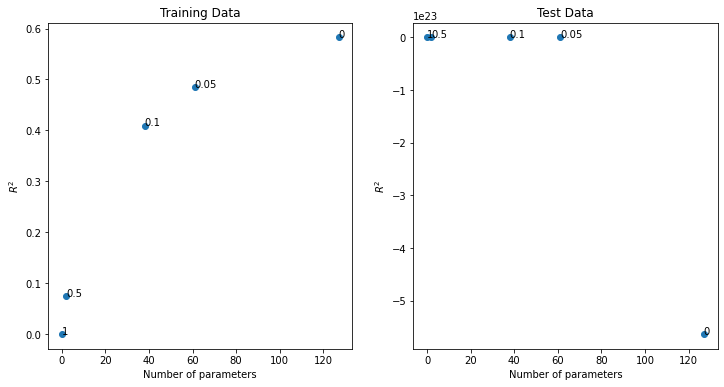

In [33]:
# Plot the R2 values of the models
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(n_params, train_r2s)
for i in range(len(n_params)):
    plt.text(n_params[i], train_r2s[i], s=alphas[i])
plt.xlabel('Number of parameters')
plt.ylabel('$R^2$')
plt.title('Training Data')

plt.subplot(1,2,2)
plt.scatter(n_params, test_r2s)
for i in range(len(n_params)):
    plt.text(n_params[i], test_r2s[i], s=alphas[i])
plt.xlabel('Number of parameters')
plt.ylabel('$R^2$')
plt.title('Test Data')
plt.show()


In [34]:
train_r2s

array([0.        , 0.07392119, 0.40888143, 0.48509096, 0.58247734])

In [35]:
# Create summary dataframes
summary = {}
for alpha in alphas:
    summary[alpha] = pd.DataFrame(columns=['feature', 'coeff'], data=np.array([X.columns[coeffs[alpha] > 0], coeffs[alpha][coeffs[alpha] > 0]]).T)
    summary[alpha] = summary[alpha].join(metadata, on='feature')
    summary[alpha].sort_values(by='coeff', inplace=True, ascending=False)

In [36]:
summary[0]

feature        coeff  \
17  clz_cl_smj-11.0  4.65692e+12   
22   clz_cl_smj-7.0  4.01128e+12   
25   clz_cl_smj-8.0  3.44069e+12   
27  clz_cl_smj-10.0  3.40119e+12   
55   pnv_cl_smj-8.0  2.98392e+12   
..              ...          ...   
13       hdi_ix_sav    0.0802942   
2        DIS_AVG_LS    0.0800061   
60   wet_cl_smj-6.0    0.0694635   
1          AREA_SKM    0.0675904   
63  wet_cl_smj-10.0    0.0422358   

                                          description  
17                                                NaN  
22                                                NaN  
25                                                NaN  
27                                                NaN  
55                                                NaN  
..                                                ...  
13                    Average human development index  
2   Long-term average discharge, in liters per second  
60                                                NaN  
1                           Surface area of reservoir  
63                                                NaN  

[70 rows x 3 columns]